Learning a Hamiltonian with Symbolic Regression: Pyoperon
===============================================

In [61]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler
from sympy.parsing import parse_expr
from sympy import lambdify, symbols
from sklearn.metrics import r2_score, mean_squared_error

from pyoperon.sklearn import SymbolicRegressor

import matplotlib.pyplot as plt
import seaborn as sns




In [62]:
data_train = pickle.load(open("Data/training.dat", "rb" ))
data_val = pickle.load(open("Data/validation.dat", "rb" ))

Now we have trunc = 8 and 12 circuit parameters of which the 12th one is dead. And 16 final amplitudes parameters. For fixed Fock numbers drop the first trunc entries in X.
First try training the final amplitudes given the initial ones and the circuit parameters ...



In [63]:
trunc = 8 
num_params = 6

x_numbers = [i for i in range(trunc , trunc + 2* num_params)]

X_train = data_train[:, x_numbers]
X_val = data_val[:,  x_numbers]


scaler_X = StandardScaler().fit(X_train)   # should use the same scaling factor from the training set

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)    # scales variables to have mean 0 and variance 1
print(scaler_X.mean_, scaler_X.var_)

X_train.shape, X_val.shape,data_train.shape



[0.0499203  0.04991542 0.05005972 0.04989196 0.05011911 0.05011452
 0.05011719 0.04994898 0.04979833 0.04993832 0.050115   0.04998833] [0.00083128 0.00082924 0.00083056 0.00083998 0.00083633 0.00083506
 0.00083022 0.0008355  0.00083417 0.00083251 0.00083693 0.00083901]


((100000, 12), (100000, 12), (100000, 36))

In [89]:
y_start = trunc + 2* num_params
y_numbers = [i for i in range(y_start, 3*trunc + 2* num_params)]


y_train = data_train[:, [y_numbers[0]] ]
y_val = data_val[:,  [y_numbers[0]]]


scaler_y = StandardScaler().fit(y_train)  # should use the same scaling factor from the training set

y_train_scaled = np.ravel(scaler_y.transform(y_train).reshape(-1))
y_val_scaled = np.ravel(scaler_y.transform(y_val).reshape(-1))

y_val_scaled.shape


(100000,)

In [90]:
reps = 1

values = []
for _ in range(reps):

    reg = SymbolicRegressor(
        allowed_symbols='add,sub,mul,div,pow,constant,variable',
        offspring_generator='basic',
        #optimizer_iterations=1,
        max_length=35,
        max_depth=15,
        initialization_method='btc', # can be btc, ptc2, koza, 
        n_threads=16,
        objectives = ['mae', 'length'],
        epsilon = 0,
        random_state=None,
        reinserter='keep-best',
        population_size=1500,
        generations=2000,
        # defaults
        max_evaluations=int(1e6),
        #symbolic_mode=False,
        #tournament_size=5,
        #population_size=1000,
        #generations=2000
        # local_iterations=5      
    )

    reg.fit(X_train_scaled, y_train_scaled)
    values += [t['objective_values'] for t in reg.pareto_front_]

In [91]:
model = reg.pareto_front_[8]["model"]
expression = parse_expr(model.replace("^","**"))
X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12 = symbols("X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12")
expression_function = lambdify([X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12], expression, "numpy")
y_pred = expression_function(X_val_scaled[:,0],X_val_scaled[:,1],X_val_scaled[:,2],X_val_scaled[:,3],X_val_scaled[:,4],X_val_scaled[:,5],X_val_scaled[:,6],X_val_scaled[:,7],X_val_scaled[:,8],X_val_scaled[:,9],X_val_scaled[:,10],X_val_scaled[:,11])
y_pred_train = expression_function(X_train_scaled[:,0],X_train_scaled[:,1],X_train_scaled[:,2],X_train_scaled[:,3],X_train_scaled[:,4],X_train_scaled[:,5],X_train_scaled[:,6],X_train_scaled[:,7],X_train_scaled[:,8],X_train_scaled[:,9],X_train_scaled[:,10],X_train_scaled[:,11])

r2score = r2_score(y_val_scaled, y_pred), mean_squared_error(y_val_scaled, y_pred)
print(reg.pareto_front_)

qinf = np.quantile(np.abs((y_val_scaled-y_pred)/y_val_scaled), 0.0)
qmax = np.quantile(np.abs((y_val_scaled-y_pred)/y_val_scaled), 0.99)
quantile_mask = (np.abs(y_val_scaled-y_pred) < qmax) & (np.abs(y_val_scaled-y_pred) > qinf)
r2score =       r2_score(y_val_scaled[quantile_mask], y_pred[quantile_mask])
r2score_train = r2_score(y_train_scaled, y_pred_train), mean_squared_error(y_val_scaled, y_pred)
print("This is the R^2 score: anything less than 0.8 is terrible",r2score)



[{'model': '(0.000000 + ((-0.806457) * (1.032362 * X5)))', 'variables': {'X5'}, 'tree': <pyoperon.pyoperon.Tree object at 0x298a748f0>, 'objective_values': [0.44912639260292053, 5.0], 'mean_squared_error': 0.30685141866818644, 'minimum_description_length': 107255.5859375, 'bayesian_information_criterion': -118104.875, 'akaike_information_criterion': 82824.1484375}, {'model': '(0.000000 + (0.760514 * (((-1.071836) * X5) - (0.434294 * X9))))', 'variables': {'X9', 'X5'}, 'tree': <pyoperon.pyoperon.Tree object at 0x2c12a15f0>, 'objective_values': [0.3674464821815491, 7.0], 'mean_squared_error': 0.22704480204913227, 'minimum_description_length': 103279.421875, 'bayesian_information_criterion': -148214.890625, 'akaike_information_criterion': 67763.3828125}, {'model': '(0.000000 + ((-0.752015) * ((0.415269 * X3) - (((-0.407684) * X9) - (1.084668 * X5)))))', 'variables': {'X3', 'X9', 'X5'}, 'tree': <pyoperon.pyoperon.Tree object at 0x2c126dff0>, 'objective_values': [0.2865908145904541, 9.0], '

<Axes: xlabel='Obj 1 (Tree length)', ylabel='Obj 2 (-R2)'>

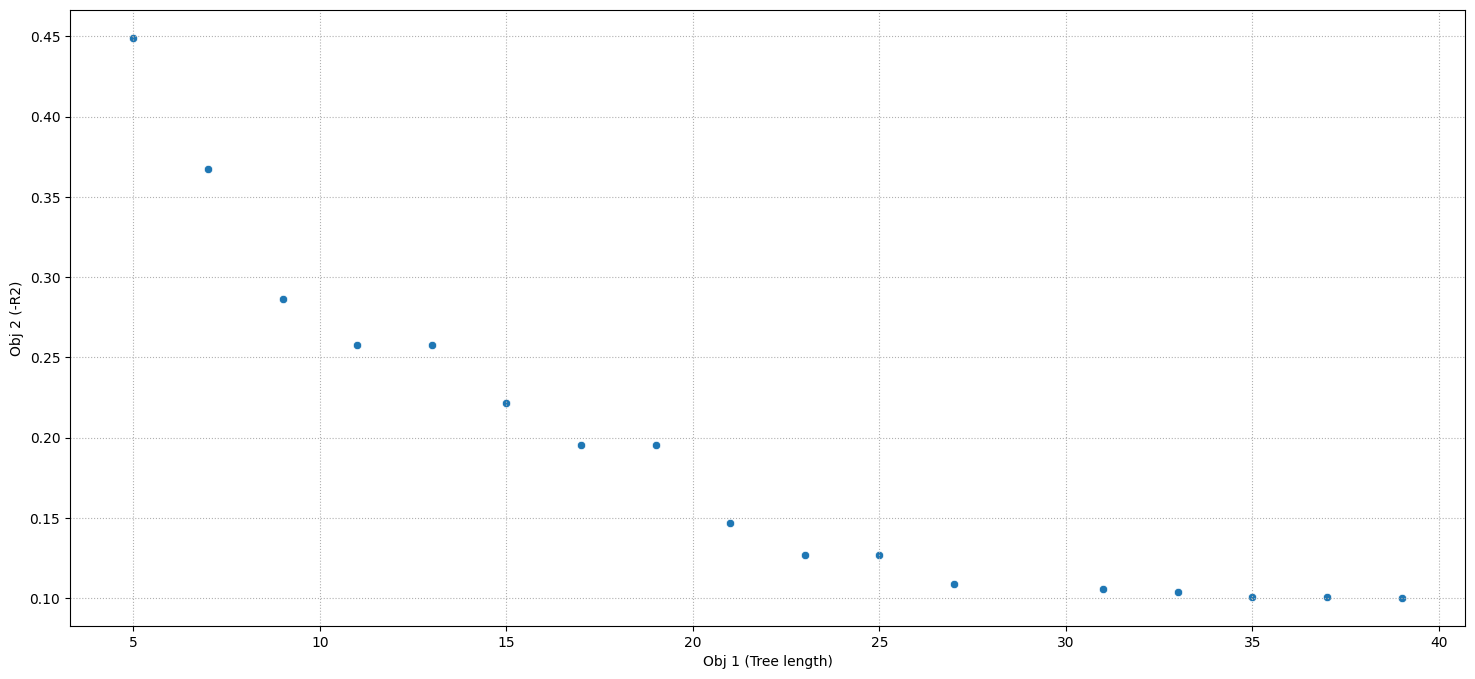

In [92]:
values = np.array(values)
fig, ax = plt.subplots(figsize=(18,8))
ax.grid(True, linestyle='dotted')
ax.set(xlabel='Obj 1 (Tree length)', ylabel='Obj 2 (-R2)')
sns.scatterplot(ax=ax, x=values[:,1], y=values[:,0])


In [93]:
qinf = np.quantile(np.abs((y_val_scaled-y_pred)/y_val_scaled), 0.0)
qmax = np.quantile(np.abs((y_val_scaled-y_pred)/y_val_scaled), 0.99)
quantile_mask = (np.abs(y_val_scaled-y_pred) < qmax) & (np.abs(y_val_scaled-y_pred) > qinf)
r2score = r2_score(y_val_scaled[quantile_mask], y_pred[quantile_mask])
print("This is the R^2 score with quantile mask: anything less than 0.8 is terrible --> ",r2score)

This is the R^2 score with quantile mask: anything less than 0.8 is terrible -->  0.9630007227820978


(-3.0, 3.0)

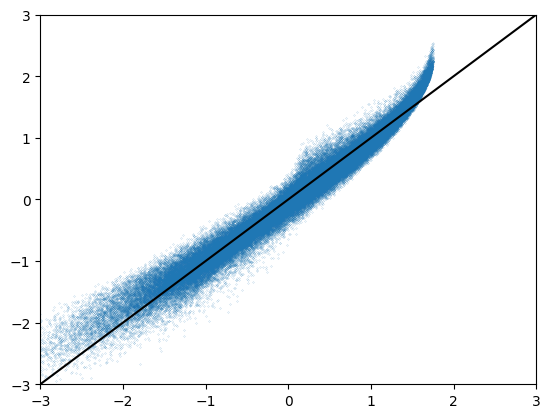

In [94]:


_x = np.linspace(-100,100,100)
_y = _x

plt.scatter(y_val_scaled, y_pred, s=0.01)
plt.plot(_x,_y, c="k")
plt.ylim(-3,3)
plt.xlim(-3,3)


In [76]:

model = reg.pareto_front_[-1]["model"]
expression = parse_expr(model.replace("^","**"))
expression

-0.164953*0.357021**(-0.187319*X3 - 1.156924*X5 + 0.383041*X9) - 0.173799589229457*X3*X7 - 0.207629805113*X3 - 0.511795219369*X5 - 0.045861552684*X6 - 0.166165569503*X7 - 0.114545401713917*X9**2 - 0.409604361574*X9 + 0.455912

In [32]:
y_pred

array([0.56680158, 0.56695045, 0.56675865, ..., 0.56679138, 0.56676573,
       0.5667534 ])